In [1]:
import os
import time
import math
import glob
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch

DEVICE = "cuda"
SAVE_PATH = 'model/unet_typ.pt'

num_classes = 5

# set device
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda


In [2]:
## Creating the dataset

In [3]:
class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        #self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['x_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means = np.array([106.623276, 14.312894, 1325.6674, 29.272326])
        self.stds = np.array([54.006954, 12.487458, 16.26564, 7.691262])
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # Load data and get label
        X = torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 7)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
path_dataset = "/media/philipp/DATA/dataset/dataset_256_ba.h5"
data = ForestDataset(path_dataset)
len(data)

100000

In [5]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

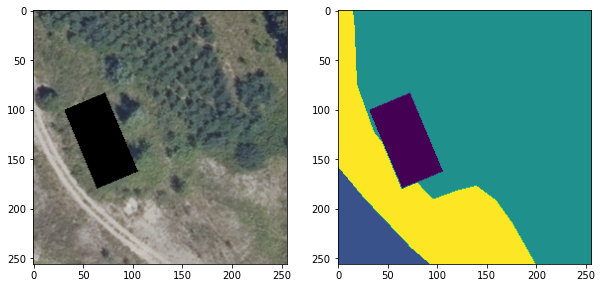

In [6]:
X, y = data[54]
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(X.permute(1, 2, 0).numpy()[:,:,:3])
ax[1].imshow(y.numpy())

In [7]:
# split data

In [8]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed = 12

# Creating data indices for training and validation splits:
dataset_size = 91000
#dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices= indices[2*split:], indices[:split], indices[split:2*split]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

54600
18200
18200


In [13]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, pin_memory=True)

In [14]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 4, 256, 256]), torch.Size([32, 256, 256]))

In [15]:
## Unet

In [16]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [17]:
# input 4 channels, output 2 classes
unet = UNET(4,num_classes)

# try to load model
try:
    #unet = torch.load(Path('model/unet_typ.pkl'))
    unet.load_state_dict(torch.load(SAVE_PATH))
    unet.to(device)
except:
    pass

In [18]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 4, 256, 256]), torch.Size([32, 256, 256]))

In [19]:

#pred = unet(xb)
#pred.shape

In [20]:
# Loss

class TverskyCrossEntropyDiceWeightedLoss(torch.nn.Module):
    
    def __init__(self, num_classes, device):
        super(TverskyCrossEntropyDiceWeightedLoss, self).__init__()
        
        self.num_classes = num_classes
        self.device = device

        
    def tversky_loss(self, pred, target, alpha=0.5, beta=0.5):
        
        target_oh = torch.eye(self.num_classes)[target.squeeze(1)]
        target_oh = target_oh.permute(0, 3, 1, 2).float()
        probs = torch.nn.functional.softmax(pred, dim=1)
        target_oh = target_oh.type(pred.type())
        
        dims = (0,) + tuple(range(2, target.ndimension()))
        inter = torch.sum(probs * target_oh, dims)
        fps = torch.sum(probs * (1 - target_oh), dims)
        fns = torch.sum((1 - probs) * target_oh, dims)
        t = (inter / (inter + (alpha * fps) + (beta * fns))).mean()
        
        return 1 - t

    
    def class_dice(self, pred, target, epsilon=1e-6):
        
        pred_class = torch.argmax(pred, dim=1)
        dice = np.ones(self.num_classes)
        for c in range(self.num_classes):
            p = (pred_class == c)
            t = (target == c)
            inter = (p * t).sum().float()
            union = p.sum() + t.sum() + epsilon
            d = 2 * inter / union
            dice[c] = 1 - d
        
        return torch.from_numpy(dice).float()

    
    def forward(self, pred, target, cross_entropy_weight=0.5,
                tversky_weight=0.5):
        
        if cross_entropy_weight + tversky_weight != 1:
            raise ValueError('Cross Entropy weight and Tversky weight should '
                             'sum to 1')
        ce = torch.nn.functional.cross_entropy(pred, target,
                           weight=self.class_dice(pred, target).to(self.device))
        tv = self.tversky_loss(pred, target)
        loss = (cross_entropy_weight * ce) + (tversky_weight * tv)
        
        return loss

In [21]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    # Reduce learning rate when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
    
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    if device != 'cpu':
                        print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    else:
                        print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)
            
            # save model
            torch.save(unet.state_dict(), SAVE_PATH)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            scheduler.step(valid_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [22]:
# start training
loss_fn = TverskyCrossEntropyDiceWeightedLoss(num_classes, device) #nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.3)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=1)

Epoch 0/0
----------
train Loss: 0.5005 Acc: 0.37013116478919983
----------


TypeError: float() argument must be a string or a number, not 'list'

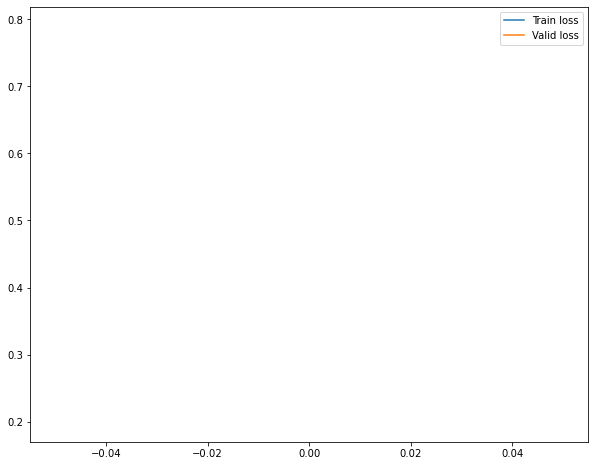

In [21]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [22]:
# predict

In [23]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [24]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(device))

predb.shape

torch.Size([32, 5, 256, 256])

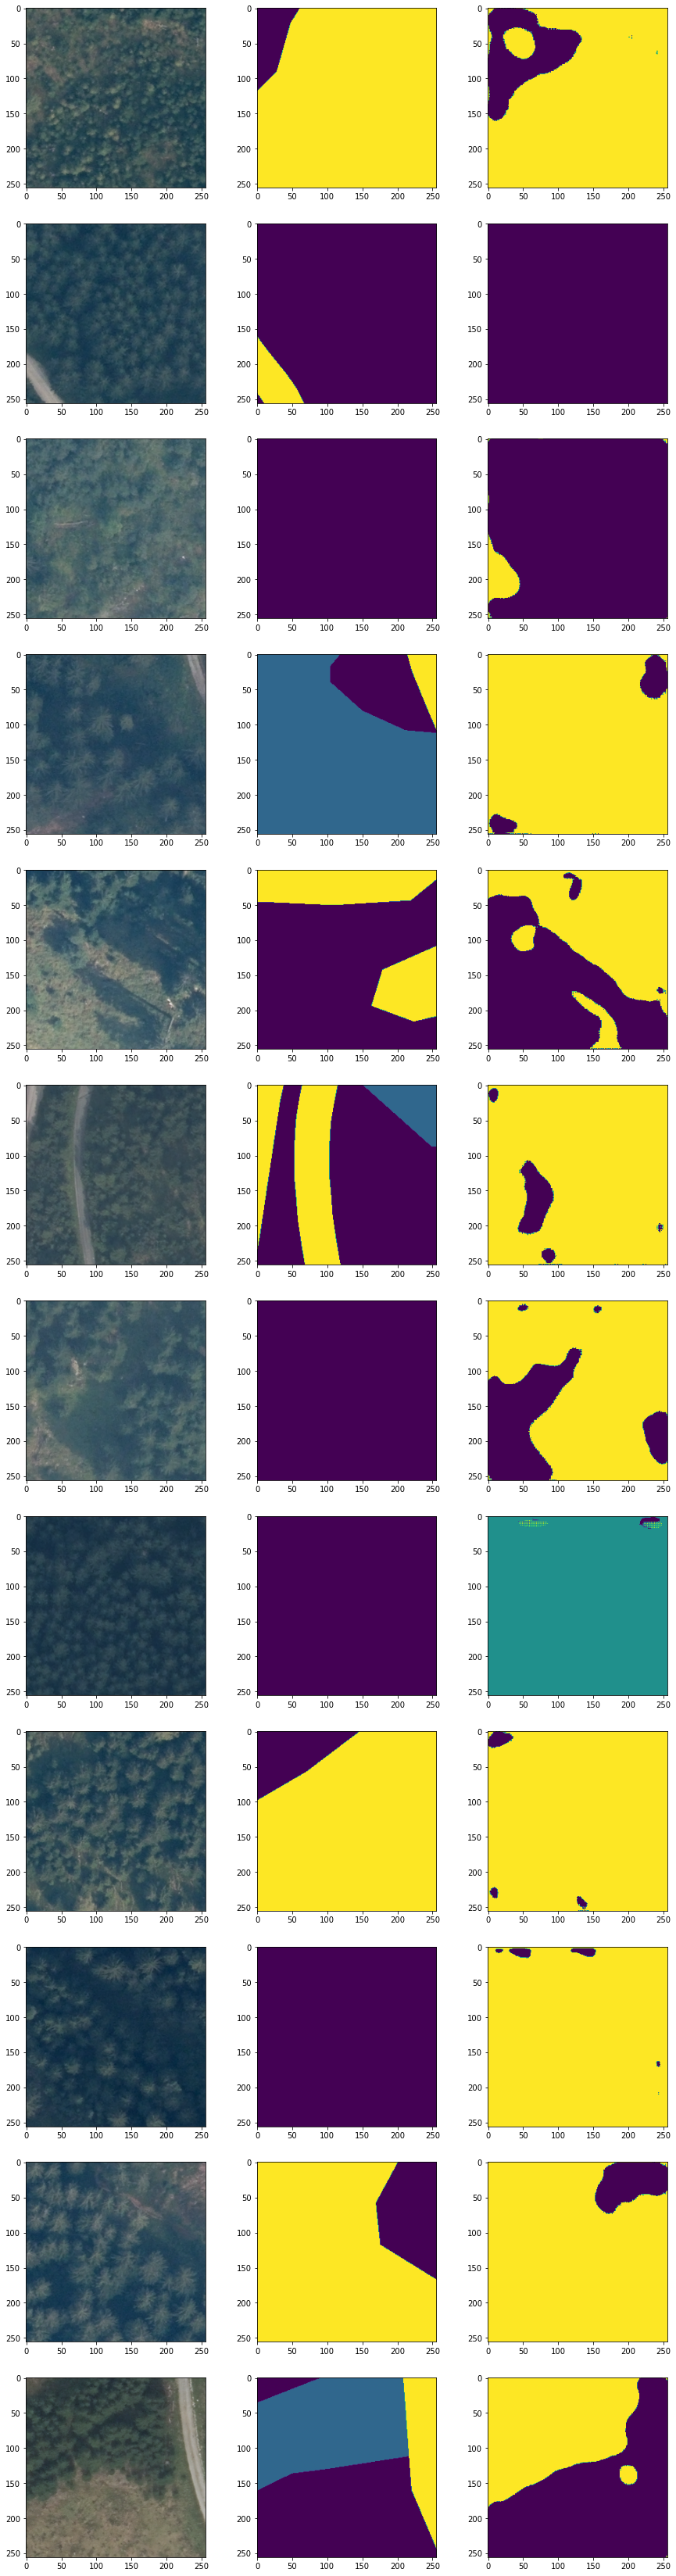

In [25]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [24]:
# save using pickle
#torch.save(unet,Path('model/unet_typ.pkl'))

# save 
torch.save(unet.state_dict(), SAVE_PATH)